# Seq2Seq Demo

保证当前路径下有data和model文件夹，data文件夹下包含npy数据

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader, RandomSampler

import numpy as np
import pandas as pd
from time import time

## 搭建模型

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoder_inputs_size, encoder_hidden_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(encoder_inputs_size, encoder_hidden_size)

    def forward(self, encoder_inputs):
        # encoder_inputs: (encoder_sequence, batch, feature)
        # encoder_outputs: (decoder_sequence, batch, encoder_hidden)
        # hidden: (layer, batch, encoder_hidden)
        
        encoder_outputs, hidden = self.gru(encoder_inputs)
        return hidden


class Decoder(nn.Module):
    def __init__(self, decoder_inputs_size, decoder_hidden_size):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(decoder_inputs_size, decoder_hidden_size)
        self.linear = nn.Linear(decoder_hidden_size, 1)

    def forward(self, decoder_inputs, hidden):
        # decoder_inputs: (1, batch, feature)
        # hidden: (1, batch, decoder_hidden)
        # decoder_output: (batch, 1)

        decoder_output, hidden = self.gru(decoder_inputs, hidden)
        decoder_output = self.linear(hidden)
        return hidden, decoder_output


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, encoder_inputs, decoder_inputs, teacher_forcing_ratio=0.5):
        # encoder_inputs: (encoder_sequence, batch, feature)
        # decoder_inputs: (decoder_sequence, batch, feature)

        encoder_seq_len = encoder_inputs.size(0)
        decoder_seq_len, batch_size, feature_size = decoder_inputs.size()
        
        # encoder_hidden: (1, batch, decoder_hidden)
        encoder_hidden = self.encoder(encoder_inputs)

        decoder_input = torch.cat([encoder_inputs[-1:][:, :, :1], decoder_inputs[:1][:, :, 1:]], dim=2)
        decoder_hidden = encoder_hidden.clone()
        decoder_outputs = torch.zeros(decoder_seq_len, batch_size, 1).to(self.device)
        for i in range(decoder_seq_len):
            # decoder_output: (1, batch, 1)
            decoder_hidden, decoder_output = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs[i] = decoder_output

            if i == decoder_seq_len - 1:
                break
            
            if np.random.random() < teacher_forcing_ratio:
                decoder_input = torch.cat([decoder_inputs[i:i + 1][:, :, :1], decoder_inputs[i + 1:i + 2][:, :, 1:]], dim=2)
            else:
                # no teacher forcing
                decoder_input = torch.cat([decoder_output, decoder_inputs[i + 1:i + 2][:, :, 1:]], dim=2)

        return decoder_outputs

## 编写数据加载器

In [ ]:
class TimeSeriesDataSet(Dataset):
    def __init__(self, data_path, mode='train'):
        self.encoder_inputs = np.load(data_path + mode + '_encoder_inputs.npy')
        self.decoder_inputs = np.load(data_path + mode + '_decoder_inputs.npy')
        self.decoder_targets = np.load(data_path + mode + '_decoder_targets.npy')

    def __len__(self):
        return len(self.encoder_inputs)

    def __getitem__(self, item):
        # item, encoder_inputs, decoder_inputs, decoder_targets
        return item, self.encoder_inputs[item], self.decoder_inputs[item], self.decoder_targets[item]

## 编写训练与评估模块

In [ ]:
def train_epoch(model, data_loader, optimizer, loss_func, teacher_forcing_ratio, clip, device):
    model.train()

    epoch_loss, total_num = 0, 0
    for i, (_, encoder_inputs, decoder_inputs, decoder_targets) in enumerate(data_loader):
        # encoder_inputs: (encoder_sequence, batch, feature)
        # decoder_inputs: (decoder_sequence, batch, feature)
        # decoder_targets: (decoder_sequence, batch, 1)

        optimizer.zero_grad()

        encoder_inputs = encoder_inputs.float().to(device).permute(1, 0, 2)
        decoder_inputs = decoder_inputs.float().to(device).permute(1, 0, 2)
        decoder_targets = decoder_targets.float().to(device).permute(1, 0, 2)

        model_outputs = model(encoder_inputs, decoder_inputs, teacher_forcing_ratio=teacher_forcing_ratio)
        loss, cnt = loss_func(model_outputs.contiguous().view(-1), decoder_targets.contiguous().view(-1))
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * cnt
        total_num += cnt

    return epoch_loss / total_num


def evaluate_epoch(model, data_loader, loss_func, device):
    model.eval()

    epoch_loss, total_num = 0, 0
    with torch.no_grad():
        for i, (_, encoder_inputs, decoder_inputs, decoder_targets) in enumerate(data_loader):
            # encoder_inputs: (encoder_sequence, batch, feature)
            # decoder_inputs: (decoder_sequence, batch, feature)
            # decoder_targets: (decoder_sequence, batch, 1)
        
            encoder_inputs = encoder_inputs.float().to(device).permute(1, 0, 2)
            decoder_inputs = decoder_inputs.float().to(device).permute(1, 0, 2)
            decoder_targets = decoder_targets.float().to(device).permute(1, 0, 2)

            # turn off teacher forcing
            model_outputs = model(encoder_inputs, decoder_inputs, teacher_forcing_ratio=0)
            loss, cnt = loss_func(model_outputs.contiguous().view(-1), decoder_targets.contiguous().view(-1))
            epoch_loss += loss.item() * cnt
            total_num += cnt

    return epoch_loss / total_num


def mse_loss(outputs, targets, reduction='elementwise_mean'):
    mse = nn.MSELoss(reduction=reduction)
    return mse(outputs, targets), outputs.numel()


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def set_seed():
    SEED = 1
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

## 开始训练

In [ ]:
DATA_PATH = 'data/'
BATCH_SIZE = 256
ENCODER_INPUTS_SIZE = 34
DECODER_INPUTS_SIZE = 30
ENCODER_HIDDEN_SIZE = 32
DECODER_HIDDEN_SIZE = 32
TEACHER_FORCING_RATIO = 0.2
CLIP = 15
LEARNING_RATE = 0.001
EPOCH_NUM = 100

set_seed()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_set = TimeSeriesDataSet(DATA_PATH, mode='train')
test_set = TimeSeriesDataSet(DATA_PATH, mode='test')
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=0)

encoder = Encoder(ENCODER_INPUTS_SIZE, ENCODER_HIDDEN_SIZE)
decoder = Decoder(DECODER_INPUTS_SIZE, DECODER_HIDDEN_SIZE)
seq2seq = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(seq2seq.parameters(), lr=LEARNING_RATE)

min_val_loss = float('inf')
not_descending_cnt = 0
for epoch in range(EPOCH_NUM):

    start_time = time()

    train_loss = train_epoch(seq2seq, train_loader, optimizer, mse_loss, TEACHER_FORCING_RATIO, CLIP, device)

    val_loss = evaluate_epoch(seq2seq, test_loader, mse_loss, device)

    end_time = time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print('Epoch: %s | Time: %sm %ss' % (str(epoch + 1).zfill(2), epoch_mins, epoch_secs))
    print('\tTrain Loss: %.3f | Val Loss: %.3f' % (train_loss, val_loss))

    if val_loss >= min_val_loss:
        not_descending_cnt += 1
        if not_descending_cnt >= 20 and epoch != EPOCH_NUM - 1:
            print('\nEarly Stopped ...')
            break
    else:
        not_descending_cnt = 0
        min_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'model/seq2seq_model.pt')
        print()
        print('model saved with validation loss', val_loss)
        print()

## 使用GPU运行

In [3]:
import das.udf.estimator as de

u_job= de.Udf(entry_point = '/mnt/wangchengming5/Demo.py', \
              image_name = 'repo.jd.local/public/notebook:nb5.5-pytorch0.4-py3-gpu', \
              train_gpu_count = 1)

In [4]:
u_job.fit(base_job_name='demo')

Started to create job demo-wangchengming5-19204137

The job is:PENDING
.
The job is:RUNNING
2019-12-19 20:42:00 Epoch: 01 | Time: 0m 12s
2019-12-19 20:42:00 	Train Loss: 2.739 | Val Loss: 1.371
2019-12-19 20:42:00 
2019-12-19 20:42:00 model saved with validation loss 1.3710176831347936
2019-12-19 20:42:00 
2019-12-19 20:42:13 Epoch: 02 | Time: 0m 12s
2019-12-19 20:42:13 	Train Loss: 0.997 | Val Loss: 0.859
2019-12-19 20:42:13 
2019-12-19 20:42:13 model saved with validation loss 0.8589853768239969
2019-12-19 20:42:13 
2019-12-19 20:42:25 Epoch: 03 | Time: 0m 12s
2019-12-19 20:42:25 	Train Loss: 0.661 | Val Loss: 0.771
2019-12-19 20:42:25 
2019-12-19 20:42:25 model saved with validation loss 0.7714134987091785
2019-12-19 20:42:25 
2019-12-19 20:42:38 Epoch: 04 | Time: 0m 12s
2019-12-19 20:42:38 	Train Loss: 0.563 | Val Loss: 0.711
2019-12-19 20:42:38 
2019-12-19 20:42:38 model saved with validation loss 0.7107120613321808
2019-12-19 20:42:38 
2019-12-19 20:42:50 Epoch: 05 | Time: 0m 12s

2019-12-19 20:54:48 	Train Loss: 0.257 | Val Loss: 0.509
2019-12-19 20:55:00 Epoch: 62 | Time: 0m 12s
2019-12-19 20:55:00 	Train Loss: 0.254 | Val Loss: 0.520
2019-12-19 20:55:13 Epoch: 63 | Time: 0m 12s
2019-12-19 20:55:13 	Train Loss: 0.254 | Val Loss: 0.551
2019-12-19 20:55:25 Epoch: 64 | Time: 0m 12s
2019-12-19 20:55:25 	Train Loss: 0.254 | Val Loss: 0.482
2019-12-19 20:55:38 Epoch: 65 | Time: 0m 12s
2019-12-19 20:55:38 	Train Loss: 0.253 | Val Loss: 0.514
2019-12-19 20:55:50 Epoch: 66 | Time: 0m 12s
2019-12-19 20:55:50 	Train Loss: 0.253 | Val Loss: 0.450
2019-12-19 20:55:50 
2019-12-19 20:55:50 model saved with validation loss 0.4498114108262699
2019-12-19 20:55:50 
2019-12-19 20:56:03 Epoch: 67 | Time: 0m 12s
2019-12-19 20:56:03 	Train Loss: 0.252 | Val Loss: 0.501
2019-12-19 20:56:15 Epoch: 68 | Time: 0m 12s
2019-12-19 20:56:15 	Train Loss: 0.251 | Val Loss: 0.484
2019-12-19 20:56:28 Epoch: 69 | Time: 0m 12s
2019-12-19 20:56:28 	Train Loss: 0.250 | Val Loss: 0.498
2019-12-19 20

# GluonTS Demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import islice
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.distribution import NegativeBinomialOutput

from demo_utils import *

mx.random.seed(1)

INFO:root:Using CPU


## 读入数据

In [2]:
sales_df = pd.read_csv('/mnt/wangchengming5/jingpin/pytorch/cid2sales/seq2seq_naive/data/cid2_794_sales.csv')
sales_df.fillna({'sale_qtty': 0}, inplace=True)

TRAIN_START = '2018-01-01'
TRAIN_END = '2019-09-28'
TEST_START = '2019-06-28'
TEST_END = '2019-11-29'
TIME_FRAME = [TRAIN_START, TRAIN_END, TEST_START, TEST_END]

## 加工特征

In [3]:
cid3_cnt = len(set(sales_df.cid3))
cid3_dict = dict(zip(sorted(set(sales_df.cid3)), range(cid3_cnt)))

sales_df = generate_holiday(sales_df, TIME_FRAME)
global_redprice_std = sales_df.groupby('item_sku_id').redprice.std().mean()
global_nominal_netprice_std = sales_df.groupby('item_sku_id').nominal_netprice.std().mean()
global_instant_price_std = sales_df.groupby('item_sku_id').instant_price.std().mean()
global_price_std = np.mean([global_redprice_std, global_nominal_netprice_std, global_instant_price_std])

sku_list = sorted(set(sales_df.item_sku_id))
train_data, validation_data, test_data = [], [], []
for i in trange(len(sku_list)):
    sku = sku_list[i]
    train_listdataset, validation_listdataset, test_listdataset = generate_sku_listdataset(sku, sales_df, TIME_FRAME, cid3_dict, global_price_std)
    if len(train_listdataset['target']) < 93:
        continue
    train_data.append(train_listdataset)
    validation_data.append(validation_listdataset)
    test_data.append(test_listdataset)
train_data = ListDataset(train_data, freq='1D')
validation_data = ListDataset(validation_data, freq='1D')
test_data = ListDataset(test_data, freq='1D')

100%|██████████| 4198/4198 [00:50<00:00, 82.63it/s]


## 模型训练

In [4]:
# train and validate
trainer = Trainer(epochs=20, batch_size=64, num_batches_per_epoch=2000, patience=5)
estimator = DeepAREstimator(freq="1D", prediction_length=62, context_length=93,
                            trainer=trainer,
                            use_feat_static_cat=True, cardinality=[cid3_cnt],
                            use_feat_dynamic_real=True,
                            distr_output=NegativeBinomialOutput())
predictor = estimator.train(training_data=train_data, validation_data=validation_data)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 2000/2000 [06:56<00:00,  4.80it/s, avg_epoch_loss=1.98]
INFO:root:Epoch[0] Elapsed time 416.821 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.976846
0it [00:00, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 28132
56it [00:07,  7.90it/s, validation_avg_epoch_loss=1.88]
INFO:root:Epoch[0] Elapsed time 7.090 seconds
INFO:root:Epoch[0] Evaluation metric 'validation_epoch_loss'=1.884881
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 2000/2000 [06:57<00:00,  4.79it/s, avg_epoch_loss=1.88]
INFO:root:Epoch[1] Elapsed time 417.800 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.881295
57it [00:07,  7.35it/s, validation_avg_epoch_loss=1.81]
INFO:root:Epoch[1] Elapsed time 7.760 seconds
INFO:root:Epoch[1] Evaluation metric 'validation_epoch_loss'=1.809666
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 2000/2000 [07:01<00:0

INFO:root:Final loss: 1.7422201517479805 (occurred at epoch 17)
INFO:root:End model training


## 模型预测

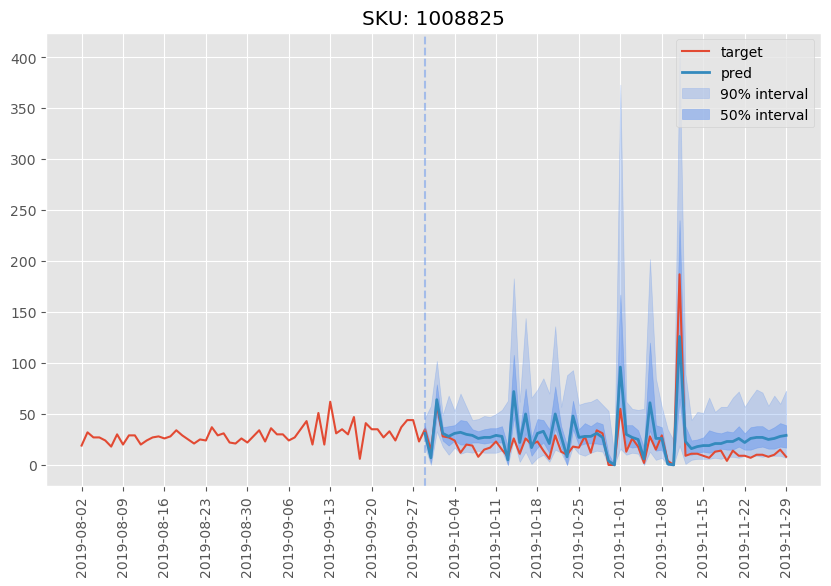

In [7]:
# inference
target_ind = 56
for i, (test_entry, forecast) in enumerate(islice(zip(validation_data, predictor.predict(test_data)), target_ind, target_ind+1)):
    sku = sku_list[target_ind]
    pred_df = plot_prediction(test_entry, forecast, sku)